<a href="https://colab.research.google.com/github/Dansoeun/AICOSS/blob/ChatBot/Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from sklearn.metrics import classification_report
import urllib.request

urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy", filename="train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy", filename="test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy", filename="train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy", filename="test_label.npy")

('test_label.npy', <http.client.HTTPMessage at 0x7a07eab58040>)

# Data Preprocessing

In [ ]:
!ls

drive  sample_data  test_label.npy  test_text.npy  train_label.npy  train_text.npy


In [ ]:
old = np.load
np.load = lambda *a, **k: old(*a, allow_pickle=True, **k)

In [ ]:
import numpy as np

intent_train = np.load(open('train_text.npy', 'rb')).tolist()
label_train = np.load(open('train_label.npy', 'rb')).tolist()

knowledge_train_path = '/content/drive/MyDrive/AICOSS/일반상식'

try:
    with open(knowledge_train_path, 'r', encoding='utf-8') as file:
        knowledge_train = file.readlines()
except Exception as e:
    print(f"파일을 불러오는 중 문제가 발생했습니다: {e}")

intent_test = np.load(open('test_text.npy', 'rb')).tolist()
label_test = np.load(open('test_label.npy', 'rb')).tolist()

In [ ]:
print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))
print('일반상식 문장의 수 :', len(knowledge_train))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600
일반상식 문장의 수 : 68539


<Axes: >

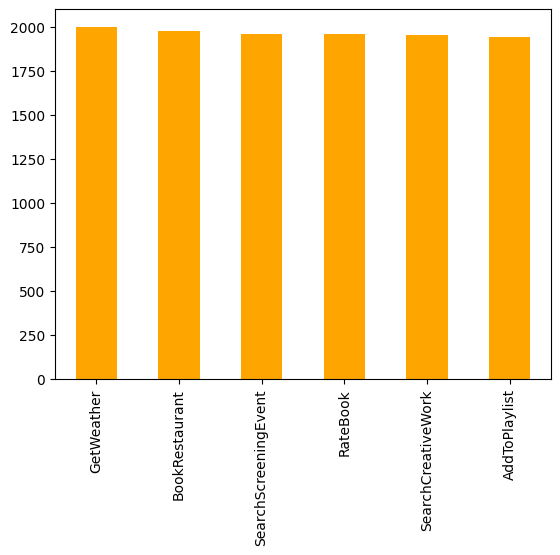

In [ ]:
temp = pd.Series(label_train)
temp.value_counts().plot(kind = 'bar',color='orange')

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

LabelEncoder()

In [ ]:
label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5]

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


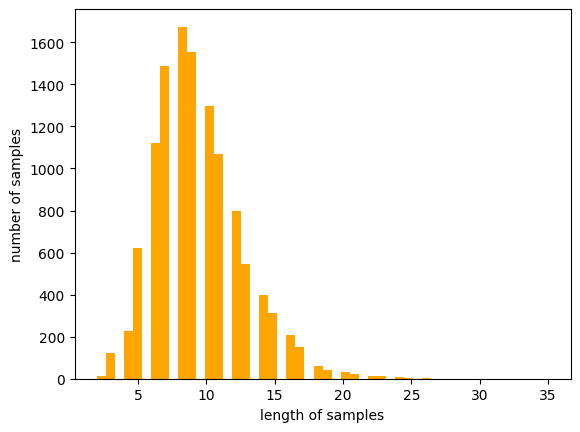

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50, color='orange')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('전체 데이터의 크기(shape):', intent_train.shape)
print('레이블 데이터의 크기(shape):', label_train.shape)


전체 데이터의 크기(shape): (11784, 35)
레이블 데이터의 크기(shape): (11784, 6)


In [ ]:
print(intent_train[0])
print(label_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
[1. 0. 0. 0. 0. 0.]


In [ ]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print(indices)

[  293  3539 11421 ...  5045  8900  4782]


In [ ]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [ ]:
n_of_val = int(0.1 * intent_train.shape[0])
print(n_of_val)

1178


In [ ]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 개수(shape):', y_train.shape)
print('검증 데이터 레이블의 개수(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 개수(shape): (10606, 6)
검증 데이터 레이블의 개수(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-08-29 14:16:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-29 14:16:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-29 14:16:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
print(embedding_dict['playlist'])
print(len(embedding_dict['playlist']))

[-0.6528   -0.087126  0.069655 -0.5048    0.79019   0.65051   0.37976
  0.20751   0.10412   0.95853   0.32161   0.36098  -0.21461  -0.59657
  0.362    -0.3951   -0.58838   0.324     1.0287    0.4569   -0.24372
 -0.26496   0.1975   -0.78302   0.17163  -0.076737  0.83705   0.58432
  0.71843   0.57522   0.11688   0.011023 -0.53676   0.73441   0.09844
  0.8927   -0.211     0.015395 -0.2928   -1.3875    1.0756    0.13387
  0.20341   0.86427  -0.096482 -0.06536  -0.52669  -0.36076   0.76218
  0.3854   -0.39054   0.014445  0.20772   0.41165  -0.16024  -0.66007
  0.13666  -0.34246   0.4382    0.49848   0.31481  -0.13102  -0.17373
  0.061581  1.1336   -0.25673  -0.20472  -0.72834   0.38054  -0.35237
  0.033096  0.43066  -0.36101  -0.096088 -0.15556  -0.028297  0.32882
  0.019752  0.5847   -0.12215  -0.53096  -0.53096   0.25334  -0.13078
 -0.058533  0.40602  -0.23493   0.048578 -0.34938   1.0172   -0.44
  1.2431   -0.32026  -0.22517  -0.079004 -0.3919    0.18961  -0.42287
 -0.028161  0.92989 ]
1

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
np.shape(embedding_matrix)

(9870, 100)

In [ ]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

In [ ]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.5

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for sz in filter_sizes:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(drop)(z)
model_output = Dense(len(label_idx), activation='softmax')(z)

model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 100)        │        987,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 34, 512)        │        102,912 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 33, 512)        │        154,112 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 31, 512)        │        256,512 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 512)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 512)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 512)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 512)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1536)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6)              │          9,222 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,509,758 (5.76 MB)

 Trainable params: 522,758 (1.99 MB)

 Non-trainable params: 987,000 (3.77 MB)

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data = (X_val, y_val))

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - acc: 0.8512 - loss: 0.4292 - val_acc: 0.9796 - val_loss: 0.0756
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 145ms/step - acc: 0.9836 - loss: 0.0551 - val_acc: 0.9830 - val_loss: 0.0579
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - acc: 0.9916 - loss: 0.0285 - val_acc: 0.9839 - val_loss: 0.0552
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - acc: 0.9951 - loss: 0.0184 - val_acc: 0.9864 - val_loss: 0.0521
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - acc: 0.9976 - loss: 0.0122 - val_acc: 0.9830 - val_loss: 0.0573
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - acc: 0.9969 - loss: 0.0093 - val_acc: 0.9830 - val_loss: 0.0557
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - acc: 0.9990 - loss: 0.0058 - val_acc: 0.9847 - val_loss: 0.0569
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - acc: 0.9989 - loss: 0.0052 - val_acc: 0.9856 - val_loss: 0.0600
Epoch 9/10
166/166 ━━━━━━━━━━━━━

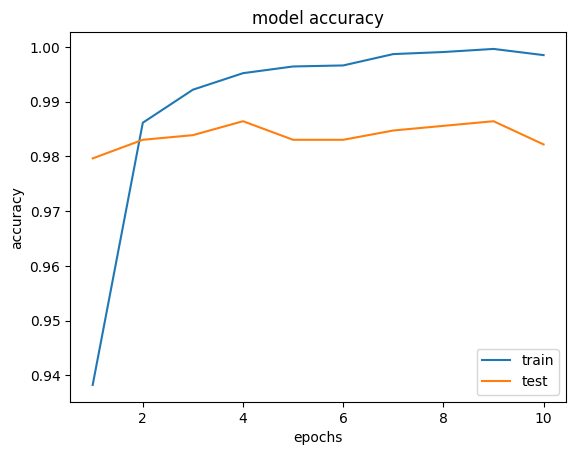

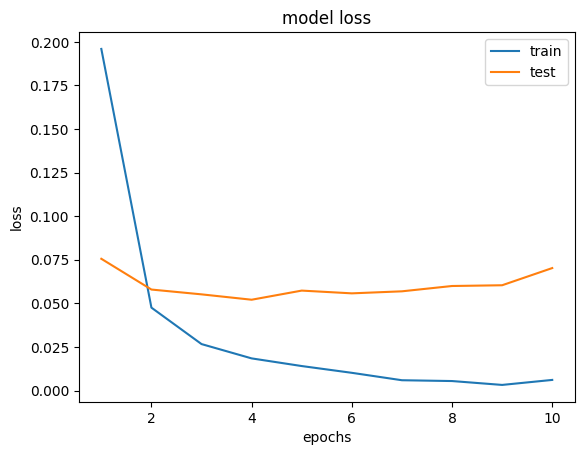

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
y_predicted = idx_encode.inverse_transform(y_predicted)
y_test = idx_encode.inverse_transform(y_test)

In [ ]:
print('accuracy: ', sum(y_predicted == y_test) / len(y_test))
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, y_predicted))

accuracy:  0.98
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       1.00      0.98      0.99       100
          GetWeather       0.99      0.99      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.91      1.00      0.95       100
SearchScreeningEvent       0.99      0.91      0.95       100

            accuracy                           0.98       600
           macro avg       0.98      0.98      0.98       600
        weighted avg       0.98      0.98      0.98       600



# Text Preprocessing

In [ ]:
import os
import json
import pandas as pd

In [ ]:
def counting(path):
    cnt = 0
    data_dir = path

    for path in os.listdir(data_dir):
        if os.path.isfile(os.path.join(data_dir, path)):
            cnt += 1

    print(f'데이터 개수 = {cnt}')
    return cnt

In [ ]:
target_path = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv", encoding = "UTF-8")

In [ ]:
target_path

,Question,Answer
0,"치대 학생인데, 장학금을 받고싶어.",https://dent.knu.ac.kr/
1,의학과 교육과정을 알려줘,https://med.knu.ac.kr/pages/sub.htm?nav_code=k...
2,컴학 공지사항 알려줘,https://cse.knu.ac.kr/bbs/board.php?bo_table=s...
3,AIcoss 학생인데 gpu 서버 사용하고 싶어,https://aicoss.knu.ac.kr/gpu/list.do
4,인컴 교육과정 알려줘,https://cse.knu.ac.kr/sub3_3_b.php
...,...,...
190,봉사활동을 가고 싶은데 어캐해야할까,https://volunteer.knu.ac.kr/
191,수강 신청 하고 싶어,https://sugang.knu.ac.kr/login.knu
192,비교과 사이트가 궁금해,https://knucube.knu.ac.kr/knucube_index.jsp
193,예대에 대해 알고 싶어,https://mvarts.knu.ac.kr/


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 23.3 MB/s eta 0:00:00


### 텍스트 전처리

In [ ]:
from konlpy.tag import Komoran

class Preprocess:
    def __init__(self, userdic=None):
        self.komoran = Komoran(userdic=userdic)

        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
        ]

    # pos 메서드 정의
    def pos(self, sentence):
        return self.komoran.pos(sentence)

    # get_keywords 메서드 정의
    def get_keywords(self, pos, without_tag=False):
        word_list = []
        for p in pos:
            if p[1] not in self.exclusion_tags:
                word_list.append(p if not without_tag else p[0])
        return word_list

# 코드 실행
sent = "컴학 공지사항을 알려줘"

p = Preprocess(userdic="/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv.tsv")

# 형태소 분석 실행
pos = p.pos(sent)

# 태그 포함 키워드 추출
ret = p.get_keywords(pos, without_tag=False)
print(ret)

# 태그 제외 키워드 추출
ret = p.get_keywords(pos, without_tag=True)
print(ret)


[('컴', 'NNG'), ('학', 'NNG'), ('공지', 'NNP'), ('사항', 'NNG'), ('알리', 'VV'), ('주', 'VX')]
['컴', '학', '공지', '사항', '알리', '주']


### 단어 사전 구축

In [ ]:
import pandas as pd

# CSV 파일을 불러오고 첫 몇 줄과 열 이름을 확인합니다.
topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

# 열 이름 출력
print(topic.columns)

Index(['Question', 'Answer'], dtype='object')


In [ ]:
import pandas as pd
from konlpy.tag import Komoran
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

topic.dropna(inplace=True)

text = list(topic['Question'])

corpus_data = text

p = Preprocess()
dict = []
for c in corpus_data:
  pos = p.pos(c)
  for k in pos:
    dict.append(k[0])

tokenizer = Tokenizer(oov_token='OOV', num_words=100000)
tokenizer.fit_on_texts(dict)
word_index = tokenizer.word_index
print(f"사전에 포함된 단어 수: {len(word_index)}")

with open("chatbot_dict.bin", "wb") as f:
    pickle.dump(word_index, f)

사전에 포함된 단어 수: 439


In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

f = open("/content/chatbot_dict.bin", "rb")
word_index = pickle.load(f)
f.close()

sent = "안녕하세요. 테스트 코드입니다. 단어사전 만들기 성공!"

p = Preprocess(userdic="/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv.tsv")

pos = p.pos(sent)

keywords = p.get_keywords(pos, without_tag=True)
for word in keywords:
  try:
    print(word, word_index[word])
  except KeyError:
    print(word, word_index['OOV'])

안녕하세요 1
테스트 1
코드 1
이 11
단어 1
사전 1
만들 401
성공 1


In [ ]:
from konlpy.tag import Komoran
import pickle

class Preprocess:
  def __init__(self, word2index_dic="/content/chatbot_dict.bin", userdic="user_dic.tsv"):
    if(word2index_dic != ''):
      f = open(word2index_dic, "rb")
      self.word_index = pickle.load(f)
      f.close()
      print("success load word_dic")
    else:
      self.word_index = None
      print("fail load word_dic")

    self.komoran = Komoran(userdic=userdic)

    self.exclusion_tags = [
        'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
        'JX', 'JC',
        'SF' 'SP', 'SS', 'SE', 'SO',
        'EP', 'EF', 'EC', 'ETN', 'ETM',
        'XSN', 'XSV', 'XSA'
    ]

  def pos(self, sentence):
    return self.komoran.pos(sentence)

  def get_keywords(self, pos, without_tag=False):
    f = lambda x: x in self.exclution_tags
    word_list = []
    for p in pos:
      if f(p[1]) is False:
        word_list.append(p if without_tag is False else p[0])
    return word_list

  def get_wordidx_sequence(self, keywords):
    if self.word_index is None:
      return []
    w2i = []
    for word in keywords:
      try:
        w2i.append(self.word_index[word])
      except KeyError:
        w2i.append(self.word_index['OOV'])
    return w2i

In [ ]:
import os
import json
import pandas as pd
from konlpy.tag import Komoran
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(sentence, word_index, max_len):
    p = Preprocess()
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)

    # 불용어 제거 및 정수 인코딩
    sequence = []
    for word in keywords:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index['OOV'])

    # 패딩 적용
    padded_sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

    return padded_sequence[0]


# 단어 집합 생성
def create_word_index(corpus_data):
    p = Preprocess()
    dict = []
    for c in corpus_data:
        pos = p.pos(c)
        for k in pos:
            dict.append(k[0])

    tokenizer = Tokenizer(oov_token='OOV', num_words=100000)
    tokenizer.fit_on_texts(dict)
    word_index = tokenizer.word_index
    print(f"사전에 포함된 단어 수: {len(word_index)}")

    with open("chatbot_dict.bin", "wb") as f:
        pickle.dump(word_index, f)

    return word_index

# 숫자 시퀀스로 변환
def convert_to_sequence(sentence, word_index):
    p = Preprocess()
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)

    sequence = []
    for word in keywords:
        try:
            sequence.append(word_index[word])
        except KeyError:
            sequence.append(word_index['OOV'])

    return sequence

# Preprocess 클래스 정의
class Preprocess:
    def __init__(self, word2index_dic="/content/chatbot_dict.bin", userdic="user_dic.tsv"):
        if word2index_dic != '':
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("Word index dictionary loaded successfully.")
        else:
            self.word_index = None
            print("Failed to load word index dictionary.")

        self.komoran = Komoran(userdic=userdic)

        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
        ]

    def pos(self, sentence):
        return self.komoran.pos(sentence)

    def get_keywords(self, pos, without_tag=False):
        word_list = []
        for p in pos:
            if p[1] not in self.exclusion_tags:
                word_list.append(p if not without_tag else p[0])
        return word_list

    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                w2i.append(self.word_index['OOV'])
        return w2i

# CSV 파일을 불러와서 데이터 준비
topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")
topic.dropna(inplace=True)

# 단어 집합 생성
corpus_data = list(topic['Question'])
word_index = create_word_index(corpus_data)

# 테스트 문장 변환
max_len = 20  # 최대 시퀀스 길이 설정
sent = "안녕하세요. 테스트 코드입니다. 단어사전 만들기 성공!"
sequence = preprocess_text(sent, word_index, max_len)
print(sequence)

Word index dictionary loaded successfully.
사전에 포함된 단어 수: 439
Word index dictionary loaded successfully.
[  1   1   1  11   1   1 401   1   0   0   0   0   0   0   0   0   0   0
   0   0]


### 의도 분류 모델 학습 데이터 생성하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Komoran
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

dataset.dropna(inplace = True)

In [ ]:
print(f"dataset shape => {dataset.shape}")

dataset shape => (195, 2)


In [ ]:
dataset.columns

Index(['Question', 'Answer'], dtype='object')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

class IntentModel:
  def __init__(self, model_name, proprocess) :
    self.labels = {0:"번호", 1:"장소", 2:"시간", 3:"기타"}
    self.model = load_model(model_name)
    self.p = proprocess

  def predict_class(self, query):
    pos = self.p.pos(query)
    keywords = self.p.get_keywords(pos, without_tag=True)
    sequences = [self.p.get_wordidx_sequence(keywords)]

    from config.GlobalParams import MAX_SEQ_LEN

    padded_segs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

    predict = self.model.predict(padded_segs)
    predict_class = tf.math.argmax(predict, axis = 1)

    return predict_class.numpy()[0]

In [ ]:
#  개체명 인식 모듈 생성
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

# 개체명 인식 모델 모듈
class NerModel:
    def __init__(self, model_name, proprocess):

        # BIO 태그 클래스별 레이블
        self.index_to_ner = {1: '0', 2:'B_DT', 3:'B_FOOD', 4: 'I', 5:'B_OG', 6:'B_PS',
                             7: 'B_LC', 8:'NNP', 9:'B_TI', 0:'PAD'}

        # 의도 분류 모델 불러오기
        self.model = load_model(model_name)

        # 챗봇 Preprocess 객체
        self.p = proprocess

    # 개체명 클래스 예측 - 질문(query)를 전달받는다.
    def predict(self, query):
        ## 형태소 분석 - 문장의 단어를 나눠 태깅 처리한다.
        pos = self.p.pos(query)

        # 각 단어마다의 품사 정보 가져오기 (불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        ## 가져온 단어에 대하여 인덱싱
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 패딩 처리 - 기존 단어 외의 나머지 40이하의 범위는 전부 0으로 처리
        max_len = 40
        padded_seqs = preprocessing.sequence.pad_sequences(sequences,
                                                           padding='post', value=0, maxlen=max_len)

        # 키워드별 개체명 예측
        predict = self.model.predict(np.array([padded_seqs[0]]))
        predict_class = tf.math.argmax(predict, axis=-1)   # argmax()를 통해 가장 높은 값의 인덱스를 반환

        # 예측된 인덱스를 index_to_ner을 통해 BIO형식으로 바꿔준다.
        tags = [self.index_to_ner[i] for i in predict_class.numpy()[0]]
        # 키워드와 예측된 태그를 압축하여 리스트화 시킨 후 반환
        return list(zip(keywords, tags))

    def predict_tags(self, query):
        # 형태소 분석
        pos = self.p.pos(query)

        # 문장 내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 패딩 처리
        max_len = 40
        padded_seqs = preprocessing.sequence.pad_sequences(sequences,
                                                           padding='post', value=0, maxlen=max_len)

        predict = self.model.predict(np.array([padded_seqs[0]]))
        predict_class = tf.math.argmax(predict, axis=-1)

        tags = []
        for tag_idx in predict_class.numpy()[0]:
            if tag_idx == 1: continue       # 만약 인덱스 태그가 1('O')이라면 건너뛰고,
            tags.append(self.index_to_ner[tag_idx]) ## 예측 결과 태그를 tags에 따로 저장

        if len(tags) == 0:  ## 태그의 길이가 0이라면 None을 반환  (*여기 줄맞춤 불확실)
            return None

        return tags

In [ ]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 846.4 kB/s eta 0:00:00


In [ ]:
import pymysql
import pymysql.cursors
import logging

class Database:
    '''
    데이터베이스 제어
    '''

    def __init__(self, host, user, password, db_name, charset='utf8'):
        self.host = host
        self.user = user
        self.password = password
        self.charset = charset
        self.db_name = db_name
        self.conn = None

    # DB 연결
    def connect(self):
        if self.conn != None:
            return

        self.conn = pymysql.connect(
            host=self.host,
            user=self.user,
            password=self.password,
            db=self.db_name,
            charset=self.charset
        )

    # DB 연결 닫기
    def close(self):
        if self.conn is None:
            return

        if not self.conn.open:
            self.conn = None
            return
        self.conn.close()
        self.conn = None

    # SQL 구문 실행
    def execute(self,sql):
        last_row_id = -1
        try:
            with self.conn.cursor() as cursor:
                cursor.execute(sql)
            self.conn.commit()
            last_row_id = cursor.lastrowid
            # logging.debug("execute last_row_id : %d", last_row_id)
        except Exception as ex:
            logging.error(ex)

        finally:
            return last_row_id

    # SELECT 구문 실행 후 단 1개의 데이터 ROW만 불러옴
    def select_one(self, sql):
        result = None

        try:
            with self.conn.cursor(pymysql.cursor.DictCursor) as cursor:
                cursor.execute(sql)
                result = cursor.fetchone()
        except Exception as ex:
            logging.error(ex)

        finally:
            return result

    # SELECT 구문 실행 후 전체 데이터 ROW 불러옴
    def select_all(self, sql):
        result = None

        try:
            with self.conn.cursor(pymysql.cursors.DictCursor) as cursor:
                cursor.execute(sql)
                result = cursor.fetchall()
        except Exception as ex:
            logging.error(ex)

        finally:
            return result

In [ ]:
# 챗봇 답변 검색 모듈
class FindAnswer:
    def __init__(self, db):
        self.db = db

    # 검색 쿼리 생성
    def _make_query(self, intent_name, ner_tags):
        sql = "select * from chatbot_train_data"
        if intent_name != None and ner_tags == None:
            sql = sql + "where intent= '{}'".format(intent_name)

        elif intent_name != None and ner_tags != None:
            where = 'where intent= "%s" ' % intent_name
            if (len(ner_tags) > 0):
                where += 'and ('
                for ne in ner_tags:
                    where += " ner like '%{}%' or ".format(ne)
                where = where[:-3] + ')'
            sql = sql + where

        # 동일한 답변이 2개 이상인 경우 랜덤으로 선택
        sql = sql + "order by rand() limit 1"
        return sql


    # 답변 검색
    def search(self, intent_name, ner_tags):
        # 의도명과 개체명으로 답변 검색
        sql = self._make_query(intent_name, ner_tags)
        answer = self.db.select_one(sql)

        # 검색되는 답변이 없으면 의도명만 검색
        if answer is None:
            sql = self._make_query(intent_name, None)
            answer = self.db.select_one(sql)

        return (answer['answer'], answer['answer_image'])

    # NER 태그를 실제 입력된 단어로 변환
    def tag_to_word(self, ner_predicts, answer):
        for word, tag in ner_predicts:

            # 변환해야 하는 태그가 있는 경우 추가
            if tag == 'B_FOOD':
                answer = answer.replace(tag, word)

        answer = answer.replace('{', '')
        answer = answer.replace('}', '')
        return answer

In [ ]:
# 챗봇 엔진 동작
from config.DatabaseConfig import *
from utils.Database import Database
from utils.Preprocess import Preprocess

# 전처리 객체 생성
p = Preprocess(word2index_dic = '/Users/dianakang/NLP/train_tools/dict/chatbot_dict.bin',
               userdic='/Users/dianakang/NLP/utils/user_dic.tsv')

# 질문/답변 학습 디비 연결 객체 생성
db = Database(
    host=DB_HOST, user=DB_USER, password=DB_PASSWORD, db_name=DB_NAME
)
db.connect()    # 디비 연결

# 원문
query = "오전에 탕수육 10개 주문합니다"

# 의도 파악
from model.intent.IntentModel import IntentModel
intent = IntentModel(model_name = '/Users/dianakang/NLP/models/intent/intent_model.h5', proprocess=p)
predict = intent.predict_class(query)
intent_name = intent.labels[predict]

# 개체명 인식
from models.ner.NerModel import NerModel
ner = NerModel(model_name='/Users/dianakang/NLP/models/ner/ner_model.h5', proprocess=p)
predicts = ner.predict(query)
ner_tags = ner.predict_tags(query)

print("질문 : ", query)
print("=" * 40)
print("의도 파악 : ", intent_name)
print("답변 검색에 필요한 NER 태그 : ", ner_tags)
print("=" * 40)

# 답변 검색
from utils.FindAnswer import FindAnswer

try:
    f = FindAnswer(db)
    answer_text, answer_image = f.search(intent_name, ner_tags)
    answer = f.tag_to_word(predicts, answer_text)
except:
    answer = "죄송해요, 무슨 말인지 모르겠어요."

print("답변 : ", answer)

db.close()  #  디비 연결 끊음

ModuleNotFoundError: No module named 'config'

### 의도 분류 모델

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Komoran
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

dataset.dropna(inplace=True)

In [ ]:
print(f"dataset shape => {dataset.shape}")

dataset shape => (195, 2)


In [ ]:
dataset.columns

Index(['Question', 'Answer'], dtype='object')

In [ ]:
number = []
place = []
time = []
etc = []

In [ ]:
for i in dataset:
    if ('어디' or '장소' or '위치' or '주소') in i: place.append(i)
    elif ('번호' or '전화') in i: number.append(i)
    elif ('시작' or '마감' or '언제' or '기간' or '시간') in i: time.append(i)
    else: etc.append(i)

In [ ]:
len(number)

0

## 의도 분류 모듈 *생성*

### 데이터 준비

In [ ]:
import pandas as pd

# 업로드된 파일의 경로
file_path = '/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv'

# 데이터셋 불러오기
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())


                     Question  \
0        치대 학생인데, 장학금을 받고싶어.    
1               의학과 교육과정을 알려줘   
2                 컴학 공지사항 알려줘   
3  AIcoss 학생인데 gpu 서버 사용하고 싶어   
4                 인컴 교육과정 알려줘   

                                              Answer  
0                            https://dent.knu.ac.kr/  
1  https://med.knu.ac.kr/pages/sub.htm?nav_code=k...  
2  https://cse.knu.ac.kr/bbs/board.php?bo_table=s...  
3               https://aicoss.knu.ac.kr/gpu/list.do  
4                 https://cse.knu.ac.kr/sub3_3_b.php  


### 데이터 전처리

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 입력 텍스트와 레이블 추출
texts = df['Question']  # 실제 텍스트가 있는 열 이름으로 변경
labels = df['Answer']  # 실제 레이블이 있는 열 이름으로 변경

# 텍스트를 시퀀스로 변환
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 패딩
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# 데이터셋을 훈련과 테스트로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 모델 구축

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 모델 생성
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.classes_), activation='softmax'))

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 요약
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 모델 학습

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step - accuracy: 0.0000e+00 - loss: 5.1104 - val_accuracy: 0.0000e+00 - val_loss: 5.1259
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.0177 - loss: 5.1067 - val_accuracy: 0.0000e+00 - val_loss: 5.1412
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.0078 - loss: 5.0846 - val_accuracy: 0.0000e+00 - val_loss: 5.2163
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 483ms/step - accuracy: 0.0052 - loss: 5.0976 - val_accuracy: 0.0000e+00 - val_loss: 5.2713
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.0424 - loss: 5.0399 - val_accuracy: 0.0000e+00 - val_loss: 5.2936
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.0121 - loss: 5.0310 - val_accuracy: 0.0000e+00 - val_loss: 5.4017
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.0021 - loss: 5.0070 - val_accuracy: 0.0000e+00 - val_loss: 5.5679
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.0112 - loss: 5.0330 -

### 모델 평가 및 저장

In [ ]:
# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# 모델 저장
model.save('intent_classification_model.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 5.5908


Test Accuracy: 0.0000


### 모델 사용

In [ ]:
# 새로운 문장 예측
def predict_intent(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(padded_sequence)
    predicted_class = encoder.inverse_transform([tf.argmax(prediction[0])])
    return predicted_class[0]

# 예시 예측
new_text = "기미코가 최초로 은퇴 선언을 한 게 언제야?"
print(predict_intent(new_text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
https://ssw.knu.ac.kr/
